# EXERCISE 1 - ML - Grundverfahren



## Submission Instructions
Please follow the steps before submission:<br>
1. Make sure that every cell is executed and the output is printed.
2. Create a PdF of the Jupyter notebook via *File $\rightarrow$ ... $\rightarrow$ PDF via LaTeX (.pdf)* or
 *File $\rightarrow$ Print Preview $\rightarrow$ Use your favorit PDF printing program*
3. Zip your created PdF file and your original notebook, i.e. the .ipynb file,
as well as your separate pen and paper solution if existent together.
4. Rename your zip file with the following naming convention: group_y_uxxxx_uxxxx_uxxxx
where y is your group number, uxxxx is the kit user from each group member/
5. Upload the zip file to Ilias. Please make sure that every group member uploads the group submission.

## 1.) Linear Regression

### 1.1) Matrix Vector Calculus (1 Point)
Rewrite the following expression as a matrix-vector product

\begin{align*}
        g = \alpha \sum_i q_i \sum_j x_{ij} \sum_k y_{jk}z_k
\end{align*}


#### $\Rightarrow$ Rewriting the expression as a matrix-vector product yields:

\begin{align*}
        g = \alpha \:
        \begin{pmatrix}
            q_0 \\ q_1 \\ ... \\ q_{m-1}
        \end{pmatrix}^\intercal
        \begin{bmatrix}
            x_{0,0} & x_{0,1} & ... & x_{0,n-1} \\
            x_{1,0} & x_{1,1} & ... & x_{1,n-1} \\
            ...     & ...     & ... & ...       \\
            x_{m-1,0} & x_{m-1,1} & ... & x_{m-1,n-1}
        \end{bmatrix}
        \begin{bmatrix}
            x_{0,0} & x_{0,1} & ... & x_{0,o-1} \\
            x_{1,0} & x_{1,1} & ... & x_{1,o-1} \\
            ...     & ...     & ... & ...       \\
            x_{n-1,0} & x_{n-1,1} & ... & x_{n-1,o-1}
        \end{bmatrix}
        \begin{pmatrix}
            z_0 \\ z_1 \\ ... \\ q_{o-1}
        \end{pmatrix}
\end{align*}



### Ridge Regression

Let's first get the data


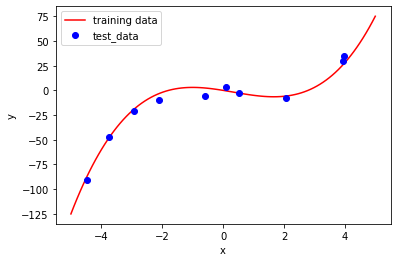

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# Load data

training_data = np.load('training_data.npy')
test_data = np.load('test_data.npy')

test_data_x = test_data[:, 0]
test_data_y = test_data[:, 1]

training_data_x = training_data[:, 0]
training_data_y = training_data[:, 1]

# Visualize data
plt.plot(test_data_x, test_data_y, 'r')
plt.plot(training_data_x, training_data_y, 'ob')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(["training data", "test_data"])

As in the lecture notebook, we will use polynomial-features here again. The following functions will be used for calculating polynomial features, evaluating the model and calculating the Mean Squarred Error for assigning a performance to each model. <br><br>
Note that we have a different function called 'get_mean_std_trainset_features' here. This function will return the mean and the standard devition of the training feature matrix. We will use the mean and the standard deviation to normalize our features according to:
\begin{align*}
    \boldsymbol{\tilde{\Phi}} = \frac{\boldsymbol{\Phi}(\boldsymbol{x}) - \boldsymbol{\mu}_{\Phi}}{\boldsymbol{\sigma}_{\Phi}}, 
\end{align*}
where $\boldsymbol{\tilde{\Phi}}$ are the (approximately) normalized features to any input
$\boldsymbol{x}$ (not necessarily the training data), $\boldsymbol{\mu}_{\Phi}$ is the mean of the features applied to the training data and $\boldsymbol{\sigma}_{\Phi}$ is the standard deviation of the features applied to the training data for each dimension.<br>
Normalization is a standard technique used in Regression to avoid numerical problems and to obtain better fits for the weight vectors $\boldsymbol{w}$. Especially when the features transform the inputs to a very high value range, normalization is very useful. In this homework we will use features of degree 10. Since the input range of the data is roughly from -4 to 4 this will lead to very high values for higher order degrees. By normalizing each dimension of the feature matrix, we will map each dimension of the feature matrix applied to the training data to a zero mean unit variance distribution. 

In [2]:
# Function for calculating the mean and standard deviation of the training feature set
def get_mean_std_trainset_features(data: np.ndarray, degree:float) -> Tuple[np.ndarray, np.ndarray]:
    """
    :param data: training data points, shape: [n_samples](we have 1-dim data)
    :param degree: degree of your polynomial, shape: scalar
    :return mean_feat: mean vector of the features applied to the training data, shape:[1 x (degrees+1)]
    :return std_feat: standard deviation vector(standard deviation for each dimension in feature matrix),
                      shape: [1 x (degrees+1)] 
    """
    unnormalized_features = get_polynomial_features(data, degree, None, None)
    mean_feat = np.mean(unnormalized_features, axis=0, keepdims=True)
    mean_feat[:, 0] = 0.0 # we don't want to normalize the bias
    std_feat = np.std(unnormalized_features, axis=0, keepdims=True)
    std_feat[:, 0] = 1.0 # we don't want to normalize the bias
    return mean_feat, std_feat

# Function to create Feature Matrix
def get_polynomial_features(data: np.ndarray, degree:float, mean_train_features: np.ndarray, std_train_features: np.ndarray) ->np.ndarray:
    """
    :param data: data points you want to evaluate the polynomials, shape: [n_samples] (we have 1-dim data) 
    :param degree: degree of your polynomial, shape: scalar
    :param mean_train_features: mean of the feature matrix for the training set, shape:[1 x (degrees+1)]
    :param std_train_features: standard deviation of the feature matrix for the training set, shape: [1 x (degrees+1)]
    :return features: feature matrix, shape: [n_data x (degree+1)]  
    Extends the feature matrix according to the matrix form discussed in the lectures. 
    """
    features = np.ones(data.shape)
    for i in range(degree):
        features = np.column_stack((features, (data)**(i+1)))
    
    if mean_train_features is not None: # if mean_test_features is None, do not normalize
        # note: features: (n_samplesxn_dims), mean_train_features: (1xn_dims), std_train_features: (1xn_dims)
        #       due to these dimensionalities we can do element-wise operations. By this we normalize each 
        #       dimension independantly
        norm_feat = (features-mean_train_features)/(std_train_features)
        return norm_feat
    else:
        return features

# Evaluate the models

def eval(Phi:np.ndarray, w:np.ndarray)->np.ndarray:
    """
    : param Phi: Feature matrix, shape: [n_data x (degree+1)]
    : param w: weight vector, shape: [degree + 1] 
    : return : predictions, shape [n_data] (we have 1-dim data)
    Evaluates your model
    """
    return np.dot(Phi, w)


def mse(y_target:np.ndarray, y_pred:np.ndarray)->np.ndarray:
    """
    :param y_target: the target outputs, which we want to have, shape: [n_data] (here 1-dim data)
    :param y_pred: the predicted outputs, shape: [n_data](we have 1-dim data)
    :return : The Mean Squared Error, shape: scalar
    """
    dif = y_target - y_pred
    return np.sum(dif ** 2, axis=0) / y_pred.shape[0]

### 1.2) Ridge Regression Weights (4 Points)
Derive the weight updates for ridge regressin in matrix form. Hint: You will need derivatives for vectors/matrices. Start
from the matrix objective for ridge regression as stated here

\begin{align*}
L &= (\boldsymbol{y}-\boldsymbol{\Phi} \boldsymbol{w})^T(\boldsymbol{y}-\boldsymbol{\Phi} \boldsymbol{w}) + \lambda \boldsymbol{w}^T \boldsymbol{I} \boldsymbol{w}. \\
\end{align*}

### 1.3) Implement Ridge Regression Weights (2 Point)
The following function will calculate the weights for ridge regression. Fill in the missing code according to the formula for calculating the weight updates for ridge regression. <br>
Recall that the formula is given by 
\begin{align*}
    \boldsymbol{w} &= (\boldsymbol{\Phi} ^T \boldsymbol{\Phi} + \lambda \boldsymbol{I} )^{-1} \boldsymbol{\Phi}^T \boldsymbol{y},
\end{align*}
where $\boldsymbol{\Phi}$ is the feature matrix (the matrix storing the data points applied to the polynomial features). Hint: use np.linalg.solve for solving for the linear equation. If you got confused because of the normalization described before, don't worry, you do not need to consider it here :)

In [3]:
def calc_weights_ridge(Phi:np.ndarray, y:np.ndarray, ridge_factor:float)->np.ndarray:
    """
    :param Phi: Feature Matrix, shape: [n_data x (degree+1)]
    :param y: Output Values, [n_data] (we have 1-dim data)
    :param ridge_factor: lambda value, shape: scalar
    :return : The weight vector, calculated according to the equation shown before, shape: [degrees +1]
    """
    ##################
    ##TODO
    #################

For demonstrating ridge regression we will pick the polynomial degree of 10. In the lecture notebook we have seen that this model is highly overfitting to the data. We will investigate the role of the ridge factor $\lambda$. For that purpose we first need to calculate the weights for different $\lambda$ values. <br>
We will pick $\lambda = [1e-{6}, 1e-{3}, 1, 3, 5,10,20,30,40,50, 1e2, 1e3, 1e5] $ to see the differences of the values. <br><br>
Practical note. We use here very high values for $\lambda$ for demonstration purposes here. In practice we would not choose a model where we know from beginning that it is highly overfitting. When choosing an appropriate model, the value needed for $\lambda$ automatically will be small (often in the range of $1e^{-6}$ or smaller).

In [4]:
# Let's do it on polynomial degree 10 and see the results

# first we get the mean and the standard deviation of the training feature matrix, which we will use for normalization
mean_train_feat, std_train_feat = get_mean_std_trainset_features(training_data_x, 10) 

# now we can calculate the normalized features for degree 10
poly_10_train = get_polynomial_features(training_data_x, 10, mean_train_feat, std_train_feat)
poly_10_test = get_polynomial_features(test_data_x, 10, mean_train_feat, std_train_feat)
ridge_factors = [1e-6, 1e-3, 1, 3, 5, 10, 20, 30, 40, 50, 1e2, 1e3, 1e5]
weights_ridge = []

for lambda_val in ridge_factors:
    weights_ridge.append(calc_weights_ridge(poly_10_train, training_data_y, lambda_val))
    
# We further have to perform the predictions based on the models we have calculated
y_training_ridge = []
y_test_ridge = []

for w in weights_ridge:
    y_training_ridge.append(eval(poly_10_train, w))
    y_test_ridge.append(eval(poly_10_test, w))

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

We are interested in the mean squarred error on the test and the training data. For that purpose we calculate them here and plot the errors for different $\lambda$ values in log space. 

In [ ]:
training_error_ridge = []
test_error_ridge = []

for i in range(len(y_training_ridge)):
    training_error_ridge.append(mse(training_data_y, y_training_ridge[i]))
    test_error_ridge.append(mse(test_data_y, y_test_ridge[i]))

error_fig_ridge = plt.figure()
plt.figure(error_fig_ridge.number)
plt.title("Error Plot Ridge Regression")
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
x_axis = ["$1e-{6}$", "$1e-{3}$", "$1$", "$3$", "$5$","$10$","$20$","$30$","$40$","$50$", 
          "$1e2$", "$1e3$", "$1e5$"]
plt.yscale('log')
plt.plot(x_axis, training_error_ridge, 'b')
plt.plot(x_axis, test_error_ridge, 'r')
# let's find the index with the minimum training error
min_error_idx = np.argmin(test_error_ridge)
plt.plot(x_axis[min_error_idx], test_error_ridge[min_error_idx], 'xg')
plt.legend(['Training Error', 'Test Error', 'Min Test Error'])

In [ ]:
# Let us visualize the newly fitted model with the optimal lambda value here
x = np.linspace(-5, 5, 100)
y_pred = eval(get_polynomial_features(x, 10, mean_train_feat, std_train_feat), weights_ridge[min_error_idx])

plt.plot()
plt.plot(test_data_x, test_data_y, 'r')
plt.plot(training_data_x, training_data_y, 'ob')
plt.plot(x, y_pred)

### 1.4) Error Plot (1 Point)
In the lecture we have seen the error plot for polynomial degrees (slide 44).
Draw a connection to the conclusions regarding over- and underfitting learned in the lecture to the
different values for $\lambda$ here. What is characteristic for overfitting and what is charecteristic for
underfitting with respect to the $\lambda $ values? Hint: Do not forget that we are in log space. Small changes in the y-axis mean high differences in the error values. <br><br>



# Probability Basics and Linear Classification


## First Example (Two Moons)

Let us start by loading a very simple toy dataset, the "two moons".

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Callable

data = dict(np.load("two_moons.npz", allow_pickle=True))
samples = data["samples"]
labels = data["labels"]

c0_samples = samples[labels == 0]
c1_samples = samples[labels == 1]

plt.figure("Data")
plt.scatter(x=c0_samples[:, 0], y=c0_samples[:, 1])
plt.scatter(x=c1_samples[:, 0], y=c1_samples[:, 1])
plt.legend(["c0", "c1"])

Let us also define some plotting utility

In [ ]:
def draw_2d_gaussian(mu: np.ndarray, sigma: np.ndarray, plt_std: float = 2, *args, **kwargs) -> None:
    (largest_eigval, smallest_eigval), eigvec = np.linalg.eig(sigma)
    phi = -np.arctan2(eigvec[0, 1], eigvec[0, 0])

    plt.scatter(mu[0:1], mu[1:2], marker="x", *args, **kwargs)

    a = plt_std * np.sqrt(largest_eigval)
    b = plt_std * np.sqrt(smallest_eigval)

    ellipse_x_r = a * np.cos(np.linspace(0, 2 * np.pi, num=200))
    ellipse_y_r = b * np.sin(np.linspace(0, 2 * np.pi, num=200))

    R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
    r_ellipse = np.array([ellipse_x_r, ellipse_y_r]).T @ R
    plt.plot(mu[0] + r_ellipse[:, 0], mu[1] + r_ellipse[:, 1], *args, **kwargs)

# plot grid for contour plots
plt_range = np.arange(-1.5, 2.5, 0.01)
plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

## 2): Classification using Generative Models (Naive Bayes Classifier)

We first try a generative approach, the Naive Bayes Classifier.
We model the class conditional distributions $p(\boldsymbol{x}|c)$ as Gaussians, the class prior $p(c)$ as
Bernoulli and apply bayes rule to compute the class posterior $p(c|\boldsymbol{x})$.

### 2.1): Implementing Generative Classifier (3 Points):
Fill in the missing code snippets below such that code runs and a prediction is made by the classifier.
The final accuracy should be 87%.

Recall that the density of the Multivariate Normal Distribution is given by

$$ p(\boldsymbol{x}) = \mathcal{N}\left(\boldsymbol{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma} \right) = \dfrac{1}{\sqrt{\det \left(2 \pi \boldsymbol{\Sigma}\right)}} \exp\left( - \dfrac{(\boldsymbol{x}-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\boldsymbol{x}-\boldsymbol{\mu})}{2}\right) $$



In [ ]:
def mvn_pdf(x: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    """
    Density of the Multivariate Normal Distribution
    :param x: samples, shape: [N x dimension]
    :param mu: mean, shape: [dimension]
    :param sigma: covariance, shape: [dimension x dimension]
    :return p(x) with p(x) = N(mu, sigma) , shape: [N] 
    """
    norm_term = 1 / np.sqrt(np.linalg.det(2 * np.pi * sigma))
    diff = x - np.atleast_2d(mu)
    exp_term = np.sum(np.linalg.solve(sigma, diff.T).T * diff, axis=-1)
    return norm_term * np.exp(-0.5 * exp_term)

**Practical Aspect:** In praxis you would never implement it like that, but stay
in the log-domain. Also for numerically stable implementations of the multivariate normal density the symmetry and
positive definitness of the covariance should be exploited by working with it's Cholesky decomposition.

The maximum likelihood estimator for a Multivariate Normal Distribution is given by
$$ \boldsymbol{\mu} = \dfrac{1}{N} \sum_{i}^N \boldsymbol{x}_i \quad \quad \boldsymbol{\Sigma} = \dfrac{1}{N} \sum_{i}^N (\boldsymbol{x}_i - \boldsymbol{\mu}) (\boldsymbol{x}_i - \boldsymbol{\mu})^T. $$
### 2.2): Derivation of Maximum Likelihood Estimator (4 Points):
Derive the maximum likelihood estimator for Multivariate Normal distributions, given above.
This derivations involves some matrix calculus.
Matrix calculus is a bit like programming, you google the stuff you need and then plug it together in the right order.
Good resources for such rules are the "matrix cookbook" (https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) and the Wikipdia article about matrix calculus
(https://en.wikipedia.org/wiki/Matrix_calculus ). State all rules you use explicitly
(except the ones given in the hints below). 

**Remark** There are different conventions of how to define a gradient (as column-vector or row-vector). This results in different ways to write the Jacobian and thus different, usually transposed, matrix calculus rules:
- In the lecture we define the gradient as column-vector 
- In the Wikipedia article this convention is referred to as "Denominator Layout". It also contains a nice explanaiton of the different conventions for the gourmets among you ;) 
- The Matrix Cookbook uses the same convention (gradient as column vector)
- Please also use it here

**Hint** Here are two of those rules that might come in handy

$\dfrac{\partial\log\det(\boldsymbol{X})}{\partial \boldsymbol{X}} = \boldsymbol{X}^{-1}$

$\dfrac{\partial \boldsymbol{x}^T\boldsymbol{A}\boldsymbol{x}}{\partial \boldsymbol{x}} = 2 \boldsymbol{A}\boldsymbol{x}$ for symmetric matrices $\boldsymbol{A}$ (Hint hint: covariance matrices are always
symmetric)

There is one missing to solve the exercise. You need to find it yourself. (Hint hint: Look in the matrix cookbook, chapter 2.2)

In [ ]:
def mvn_mle(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Maximum Likelihood Estimation of parameters for Multivariate Normal Distribution
    :param x: samples shape: [N x dimension]
    :return mean (shape: [dimension]) und covariance (shape: [dimension x dimension]) that maximize likelihood of data.
    """
    ##################
    ##TODO
    #################


We can now use this maximum likelihood estimator to fit generative models to the samples of both classes. Using those models and some basic rules of probability we can obtain the class posterior distribution $p(c|\boldsymbol{x})$

In [ ]:
# Fit Gaussian Distributions using the maximum likelihood estimator to samples from both classes
mu_c0, sigma_c0 = mvn_mle(c0_samples)
mu_c1, sigma_c1 = mvn_mle(c1_samples)

# Prior obtained by "counting" samples in each class
p_c0 = c0_samples.shape[0] / samples.shape[0]
p_c1 = # TODO

def compute_posterior(
        samples: np.ndarray,
        p_c0: float, mu_c0: np.ndarray, sigma_c0: np.ndarray,
        p_c1: float, mu_c1: np.ndarray, sigma_c1: np.ndarray) \
        -> Tuple[np.ndarray, np.ndarray]:
    """
    computes the posteroir distribution p(c|x) given samples x, the prior p(c) and the
    class conditional likelihood p(x|c)
    :param samples: samples x to classify, shape: [N x dimension]
    :param p_c0: prior probability of class 0, p(c=0) 
    :param mu_c0: mean of class conditional likelihood of class 0, p(x|c=0) shape: [dimension]
    :param sigma_c0: covariance of class conditional likelihood of class 0, p(x|c=0) shape: [dimension x dimension]
    :param p_c1: prior probability of class 1 p(c=1) 
    :param mu_c1: mean of class conditional likelihood of class 1 p(x|c=1) shape: [dimension]
    :param sigma_c1: covariance of class conditional likelihood of class 1, p(x|c=1) shape: [dimension x dimension]
    :return two arrays, p(c=0|x) and p(c=1|x), both shape [N]
    """
    ##################
    ##TODO
    #################


p_c0_given_x, p_c1_given_x = compute_posterior(samples, p_c0, mu_c0, sigma_c0, p_c1, mu_c1, sigma_c1)
# Prediction
predicted_labels = np.zeros(labels.shape)
# break at 0.5 arbitrary
predicted_labels[p_c0_given_x >= 0.5] = 0.0  # is not strictly necessary since whole array already zero.
predicted_labels[p_c1_given_x > 0.5] = 1.0

# Evaluate
acc = (np.count_nonzero(predicted_labels == labels)) / labels.shape[0]
print("Accuracy:", acc)

Lets look at the class likelihoods

In [ ]:
plt.title("Naive Bayes")
plt.scatter(x=samples[labels == 0, 0], y=samples[labels == 0, 1], c="blue")
draw_2d_gaussian(mu_c0, sigma_c0, c="blue")
plt.scatter(x=samples[labels == 1, 0], y=samples[labels == 1, 1], c="orange")
draw_2d_gaussian(mu_c1, sigma_c1, c="orange")
plt.legend(["c0", "c1"])

And the final posterior distribution for the case $p(c=1|\boldsymbol{x})$

In [ ]:
pred_grid = np.reshape(compute_posterior(flat_plt_grid, p_c0, mu_c0, sigma_c0,
                                         p_c1, mu_c1, sigma_c1)[1], plt_grid_shape)
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)
plt.colorbar()

s0 = plt.scatter(c0_samples[..., 0], c0_samples[..., 1], color="blue")
s1 = plt.scatter(c1_samples[..., 0], c1_samples[..., 1], color="orange")
plt.legend([s0, s1], ["c0", "c1"])

plt.xlim(-1.5, 2.5)

We achieve a train accuracy of 87%.
For such a simple task that is clearly not great, but it nicely illustrates a
problem with generative approaches:
They usually depend on quite a lot of assumptions.

### 2.3) Wrong Assumptions? (1 Point):
Which untrue assumption did we make?

### Discriminative Classifier using Logistic Regression
<i> This part of the Notebook was already presented in the Lecture and is only here for reference.
 There are no tasks in this part.</i>

We start by implementing a few helper functions for affine mappings, the sigmoid function and the negative bernoulli log-likelihood.

In [ ]:
def affine_features(x: np.ndarray) -> np.ndarray:
    """
    implements affine feature function
    :param x: inputs, shape: [N x sample_dim]
    :return inputs with additional bias dimension, shape: [N x feature_dim]
    """
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)

def quad_features(x: np.ndarray) -> np.ndarray:
    """
    implements quadratic feature function
    :param x: inputs, shape: [N x sample_dim]
    :return squared features of x, shape: [N x feature_dim]
    """
    sq = np.stack([x[:, 0] ** 2, x[:, 1]**2, x[:, 0] * x[:, 1]], axis=-1)
    return np.concatenate([sq, affine_features(x)], axis=-1)

def cubic_features(x: np.ndarray) -> np.ndarray:
    """
    implements cubic feature function
    :param x: inputs, shape: [N x sample_dim]
    :return cubic features of x, shape: [N x feature_dim]
    """
    cubic = np.stack([x[:, 0]**3, x[:, 0]**2 * x[:, 1], x[:, 0] * x[:, 1]**2, x[:, 1]**3], axis=-1)
    return np.concatenate([cubic, quad_features(x)], axis=-1)

def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    the sigmoid function
    :param x: inputs 
    :return sigma(x)
    """
    return 1 / (1 + np.exp(-x))

def bernoulli_nll(predictions: np.ndarray, labels: np.ndarray, epsilon: float = 1e-12) -> np.ndarray:
    """
    :param predictions: output of the classifier, shape: [N]
    :param labels: true labels of the samples, shape: [N]
    :param epsilon: small offset to avoid numerical instabilities (i.e log(0))
    :return negative log-likelihood of the labels given the predictions
    """
    return - (labels * np.log(predictions + epsilon) + (1 - labels) * np.log(1 - predictions + epsilon))


### Optimization by Gradient Descent


First, we implement a very simple gradient descent optimizer. It iterativly applies the gradient descent rule
introduced in the lecture
$$ \boldsymbol{x}_{t+1} = \boldsymbol{x}_t - \eta \nabla f(\boldsymbol{x}_t).$$

We also add some simple stopping criteria which terminate the minimization if the algorithm has converged.

In [ ]:
def minimize(f: Callable , df: Callable, x0: np.ndarray, lr: float, num_iters: int) -> \
        Tuple[np.ndarray, float, np.ndarray, np.ndarray]:
    """
    :param f: objective function
    :param df: gradient of objective function
    :param x0: start point, shape [dimension]
    :param lr: learning rate
    :param num_iters: maximum number of iterations
    :return argmin, min, values of x for all interations, value of f(x) for all iterations
    """
    # initialize
    x = np.zeros([num_iters + 1] + list(x0.shape))
    f_x = np.zeros(num_iters + 1)
    x[0] = x0
    f_x[0] = f(x0)
    for i in range(num_iters):
        # update using gradient descent rule
        grad = df(x[i])
        x[i + 1] = x[i] - lr * grad
        f_x[i + 1] = f(x[i + 1])
    return x[i+1], f_x[i+1], x[:i+1], f_x[:i+1] # logging info for visualization


**Practical Aspect:** While such a simple gradient descent optimizer works for the task we are considering and is simple enough to implement, in practice you should always use more sophisticated optimizers (e.g. L-BFGS) and use existing implementations. Such efficient and well-tested implementations are provided by software packages such as NlOpt or scipy.optimize.

Next, we need to define the cost function and its derivative. Maximizing the likelihood is equivalent to minimizing the negative log-likelihood, which we are using here. The derivation of the gradient is given in the lecture.

Note that we do not sum the losses as in the lecutre but take the mean. This is just a multiplication with a constant, thus the optimal parameters do not change. Yet, working with the mean makes the loss, and more importantly, the length of the gradient independent of the number of samples.

In [ ]:
def objective_bern(weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> float:
    """
    bernoulli log-likelihood objective 
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape: [N]
    :return average negative log-likelihood 
    """
    predictions = sigmoid(features @ weights)
    return np.mean(bernoulli_nll(predictions, labels))

def d_objective_bern(weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    gradient of the bernoulli log-likelihood objective
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape [N]
    """
    res = np.expand_dims(sigmoid(features @ weights) - labels, -1)
    grad = features.T @ res / res.shape[0]
    return np.squeeze(grad)

Finally, we can tie everything together and get our probabilistic classifier

In [ ]:
# Generate Features from Data

# change this to play arround with feature functions
#feature_fn = affine_features
#feature_fn = quad_features
feature_fn = cubic_features
features = feature_fn(samples)

# Optimize Loss
w_bce, loss, x_history, f_x_history = \
    minimize(lambda w: objective_bern(w, features, labels),
             lambda w: d_objective_bern(w, features, labels),
             np.ones(features.shape[1]), 1, 2500)

print("Final loss:", loss)
# Plot
plt.figure()
plt.semilogy(f_x_history)
plt.xlabel("Iteration")
plt.ylabel("Negative Bernoulli Log-Likelihood")

plt.figure()
plt.title("Bernoulli LL Solution")
pred_grid = np.reshape(sigmoid(feature_fn(flat_plt_grid) @ w_bce), plt_grid_shape)

plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)
plt.colorbar()

s0 = plt.scatter(c0_samples[..., 0], c0_samples[..., 1], color="blue")
s1 = plt.scatter(c1_samples[..., 0], c1_samples[..., 1], color="orange")
plt.legend([s0, s1], ["c0", "c1"])
plt.xlim(-1.5, 2.5)

## 3) Stochastic and Batch Gradients (4 Points)
**Note** You need to run the cells above first to load the data

Usually it is cheaper to approximate the gradients on a small subset of the data, i.e. a batch. We implement a single function for this


Fill in the todos in the function below.

In [ ]:
def minimize_with_sgd(features: np.ndarray, labels: np.ndarray, initial_weights: np.ndarray, schedule: Callable,
                      num_iterations: int, batch_size: int):
    """
    :param features: all samples, shape: [N x feature_dim] 
    :param labels: all labels, shape: [N]
    :param initial_weights: initial weights of the classifier, shape: [feature_dim * K]
    :param schedule: learning rate schedule (a callable function returning the learning rate, given the iteration
    :param num_iterations: number of times to loop over the whole dataset
    :param batch_size: size of each batch, should be between 1 and size of data
    return "argmin", "min", logging info
    """

    assert 1 <= batch_size <= features.shape[0]
    # This is a somewhat simplifying assumption but for the exercise its ok
    assert features.shape[0] % batch_size == 0, "Batch Size does not evenly divide number of samples"
    batches_per_iter = int(features.shape[0] / batch_size)

    # setup
    weights = np.zeros([batches_per_iter * num_iterations + 1, initial_weights.shape[0]])
    loss = np.zeros(batches_per_iter * num_iterations + 1)
    weights[0] = initial_weights
    loss[0]= objective_bern(weights[0], features, labels)

    for i in range(num_iterations):
     #--------------------------------------------------
        # TODO: shuffle data
        #--------------------------------------------------
        for j in range(batches_per_iter):
            global_idx = i * batches_per_iter + j

             #--------------------------------------------------
            # TODO: do stochastic gradient descent update!
            #--------------------------------------------------


            # log loss (on all samples, usually you should not use all samples to evaluate after each stochastic
            # update step)
            loss[global_idx + 1] = objective_bern(weights[global_idx + 1], features, labels)
    return weights[-1], loss[-1], (weights, loss)


The loss curve is expected to look a bit jerky due to the stochastic nature of stochastic gradient descent.
If it goes down asymptotically its fine. Also, feel free to play around a bit with the schedule, num_iterations and
batch_size to see how they affect the behaviour

In [ ]:
_, l, l_info = minimize_with_sgd(features, labels, np.zeros(features.shape[1]),
                                 schedule=(lambda t: 0.25),
                                 num_iterations=25,
                                 batch_size=1)
print("Final loss", l)

plt.figure()
plt.title("Cross Entropy Loss")
plt.semilogy(l_info[1])